#### Lib Import

In [2]:
import warnings
warnings.filterwarnings("ignore")
import duckdb
import joblib
import os
import pandas as pd
import concurrent.futures
import numpy as np
import nltk
import umap.umap_ as umap
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from keybert import KeyBERT
from typing import List
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Model Import

In [3]:
tonenizer = BertTokenizer.from_pretrained('lucas-leme/FinBERT-PT-BR')
model = BertForSequenceClassification.from_pretrained('lucas-leme/FinBERT-PT-BR')
title_embedd_model = SentenceTransformer('all-MiniLM-L6-v2')

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
kw_model = KeyBERT()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Pipeline Definition

In [3]:
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tonenizer)

Device set to use cpu


#### Feature Store Functions

In [3]:
def get_sentiment(text:str):
    if text is None:
        return "Neural", 0
    result = sentiment_pipeline(text)[0]
    return result['label'], result['score']


def process_sentiment_batch(titles_batch):
    titles_batch = list(titles_batch)
    results = sentiment_pipeline(titles_batch)
    sentiment_label = [result['label'] for result in results]
    sentiment_scores = [result['score'] for result in results]
    return sentiment_label, sentiment_scores


def get_keywords(text:str) -> List[tuple]:
    result = kw_model.extract_keywords(
        docs=text,
        stop_words=stopwords,
        use_maxsum=True,
        keyphrase_ngram_range=(1, 1), 
        nr_candidates=20, 
        top_n=5
    )
    return result


def process_keywords_batch(titles_batch):
    titles_batch = list(titles_batch)
    batch_results = [get_keywords(title) for title in titles_batch]
    return batch_results


def embbed_title(df: pd.DataFrame, model_to_embbed: SentenceTransformer, column_to_embbed: str, target_column: str) -> pd.DataFrame:
    # Clean and process the title column
    df['cleaned_title'] = df['title'].str.strip()
    df[target_column] = list(model_to_embbed.encode(df['cleaned_title'].tolist(), convert_to_tensor=False))
    
    return df

def embbed_body(df: pd.DataFrame, model_to_embbed: SentenceTransformer) -> pd.DataFrame:
    # Clean and process the title column
    df['cleaned_body'] = df['body'].str.strip()
    df['content_embbeding'] = list(model_to_embbed.encode(df['cleaned_body'].tolist(), convert_to_tensor=False))
    
    return df


def drop_columns(df: pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    dropped_df = df.drop(columns=columns_to_drop, axis=1)
    return dropped_df

### Data processing with Duckdb

#### Title Sentiment Analysis

In [5]:
conn = duckdb.connect()
filepath = 'local/itens.parquet'
df = conn.execute(f"SELECT * FROM '{filepath}'").fetch_df()

In [6]:
batch_size = 100
batches = [df['title'][i:i + batch_size] for i in range(0, len(df), batch_size)]

In [7]:
sentiment_labels = []
sentiment_scores = []

In [8]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    for labels, scores in tqdm(executor.map(process_sentiment_batch, batches), total=len(batches), desc='Processing Sentiment Analysis', unit='batch'):
        sentiment_labels.extend(labels)
        sentiment_scores.extend(scores)

Processing Sentiment Analysis: 100%|██████████| 2557/2557 [1:33:49<00:00,  2.20s/batch]


In [ ]:
df_backup = df.copy()

In [10]:
df['title_sentiment_label'] = sentiment_labels
df['title_sentiment_score'] = sentiment_scores
df.head()

,page,url,issued,modified,title,body,caption,title_sentiment_label,title_sentiment_score
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,NEUTRAL,0.450133
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091


In [11]:
out_filepath = 'local/itens_1.parquet'
df.to_parquet(out_filepath, index=False)

#### Caption Sentiment Analysis

In [12]:
conn = duckdb.connect()
filepath_1 = 'local/itens_1.parquet'
df = conn.execute(f"SELECT * FROM '{filepath_1}'").fetch_df()

In [15]:
df.head()

,page,url,issued,modified,title,body,caption,title_sentiment_label,title_sentiment_score
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,NEUTRAL,0.450133
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091


In [13]:
batch_size = 100
batches = [df['caption'][i:i + batch_size] for i in range(0, len(df), batch_size)]

In [16]:
caption_sentiment_labels = []
caption_sentiment_scores = []

In [17]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    for labels, scores in tqdm(executor.map(process_sentiment_batch, batches), total=len(batches), desc='Processing Sentiment Analysis', unit='batch'):
        sentiment_labels.extend(labels)
        sentiment_scores.extend(scores)

Processing Sentiment Analysis: 100%|██████████| 2557/2557 [1:39:59<00:00,  2.35s/batch]  


In [18]:
df['caption_sentiment_label'] = caption_sentiment_labels
df['caption_sentiment_score'] = caption_sentiment_scores
df.head()

,page,url,issued,modified,title,body,caption,title_sentiment_label,title_sentiment_score,caption_sentiment_label,caption_sentiment_score
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053,NEGATIVE,0.607570
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,NEUTRAL,0.450133,NEUTRAL,0.683940
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971,NEGATIVE,0.845363
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313,NEUTRAL,0.766454
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091,NEUTRAL,0.708964


In [19]:
out_filepath = 'local/itens_2.parquet'
df.to_parquet(out_filepath, index=False)

#### Body Keywords

In [4]:
conn = duckdb.connect()
filepath_1 = 'local/itens_2.parquet'
df = conn.execute(f"SELECT * FROM '{filepath_1}'").fetch_df()

In [5]:
test = df.head(50)

In [13]:
batch_size = 100
batches_body = [df['body'][i:i + batch_size] for i in range(0, len(df), batch_size)]
keywords_list = []

In [ ]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    for batch_keywords in tqdm(
        executor.map(process_keywords_batch, batches_body),
        total=len(batches_body),
        desc='Processing Keyword Extraction',
        unit='batch'
    ):
        keywords_list.extend(batch_keywords)

Processing Keyword Extraction:   2%|▏         | 48/2557 [15:04<12:35:54, 18.08s/batch] 

#### Itens Text Pipeline

In [5]:
target_column = 'embbed_title'
column_to_embbed = 'cleaned_title'
itens_columns_to_drop_text = ['modified', 'body', 'url', 'issued', 'title']


In [6]:
itens_pipeline_text = Pipeline(
    steps=[
        ('create_embbeding', FunctionTransformer(
            embbed_title, 
            kw_args={
                'model_to_embbed': title_embedd_model,
                'column_to_embbed': column_to_embbed,
                'target_column': target_column
        })),
        # ('drop_unused_columns', FunctionTransformer(
        #     drop_columns, kw_args={'columns_to_drop': itens_columns_to_drop_text}
        # ))
    ]
)

In [7]:
conn = duckdb.connect()
filepath_1 = 'local/itens_2.parquet'
df = conn.execute(f"SELECT * FROM '{filepath_1}'").fetch_df()

In [8]:
text_pipeline = itens_pipeline_text.transform(df)
text_pipeline.head()

,page,url,issued,modified,title,body,caption,title_sentiment_label,title_sentiment_score,caption_sentiment_label,caption_sentiment_score,cleaned_title,embbed_title
0,13db0ab1-eea2-4603-84c4-f40a876c7400,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053,NEGATIVE,0.607570,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"[0.028708808, 0.07910229, -0.04915501, 0.02104..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,NEUTRAL,0.450133,NEUTRAL,0.683940,Linguajar dos santarenos é diferenciado e chei...,"[0.05066423, 0.053637918, -0.06246449, -0.0591..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971,NEGATIVE,0.845363,Ex-premiê Shinzo Abe morre após ser baleado no...,"[-0.04080393, 0.08898491, -0.041833814, -0.010..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313,NEUTRAL,0.766454,"Relator no STF, Fachin vota contra marco tempo...","[-0.02016749, 0.13216536, 0.03784579, -0.01504..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091,NEUTRAL,0.708964,"Após 2 votos, pedido de vista suspende julgame...","[0.031508345, 0.10205304, 0.03989872, 0.017708..."


In [9]:
out_filepath = 'local/itens_text.parquet'
text_pipeline.to_parquet(out_filepath, index=False)

#### Body Embbeding

In [4]:
conn = duckdb.connect()
filepath = 'local/itens.parquet'
df = conn.execute(f"SELECT * FROM '{filepath}'").fetch_df()

In [6]:
data = df[['page', 'body']]
print(data.count())

page    255603
body    255603
dtype: int64


In [29]:
data1 = data.iloc[:20000]
data2 = data.iloc[20000:40000]
data3 = data.iloc[40000:60000]
data4 = data.iloc[60000:80000]
data5 = data.iloc[80000:100000]
data6 = data.iloc[100000:120000]
data7 = data.iloc[120000:140000]
data8 = data.iloc[140000:160000]
data9 = data.iloc[160000:180000]
data10 = data.iloc[180000:200000]
data11 = data.iloc[200000:220000]
data12 = data.iloc[220000:240000]
data13 = data.iloc[240000:]

In [17]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import pandas as pd
import duckdb

def embbed_body(df: pd.DataFrame, model_to_embbed: SentenceTransformer) -> pd.DataFrame:
    # Clean and process the body column
    df['cleaned_body'] = df['body'].str.strip()
    
    # Prepare data for parallel processing
    texts = df['cleaned_body'].tolist()
    embeddings = []

    # Use ThreadPoolExecutor for multithreading and tqdm for progress tracking
    with ThreadPoolExecutor() as executor:
        # Use tqdm to track progress
        for embedding in tqdm(executor.map(model_to_embbed.encode, texts), total=len(texts), desc="Embedding bodies"):
            embeddings.append(embedding)

    # Assign embeddings to the dataframe
    df['content_embbeding'] = embeddings

    return df

In [44]:
# Apply the embedding function with multithreading and progress bar
data13 = embbed_body(data13, title_embedd_model)
# Check the output
data13.head()


Embedding bodies: 100%|██████████| 15603/15603 [03:40<00:00, 70.92it/s]


,page,body,cleaned_body,content_embbeding
240000,b47177e3-7025-4d5b-8a16-23f5985b35c3,Polícia Federal investiga crimes de tortura co...,Polícia Federal investiga crimes de tortura co...,"[0.029590202, 0.0112397345, -0.059381727, -0.0..."
240001,f501e225-2736-4bd2-9a31-44d325fc389d,Lavô oferece lavagens a seco com hora e local ...,Lavô oferece lavagens a seco com hora e local ...,"[0.048061904, 0.0032889922, 0.027649926, -0.05..."
240002,46ccdc6a-2899-4b2e-b468-99e096c048c6,Pacote com nove projetos quer mudar lei brasil...,Pacote com nove projetos quer mudar lei brasil...,"[-0.009928917, -0.0066172793, -0.08729363, -0...."
240003,fd826f13-1d23-4a20-b393-5fd4a2fdd490,Homem suspeito de matar policial federal em Sã...,Homem suspeito de matar policial federal em Sã...,"[0.019079493, 0.03009774, -0.036316227, -0.018..."
240004,368d86e3-ccb3-4374-a2a7-227e3707fcba,Startup lança franquia de imobilizador ortopéd...,Startup lança franquia de imobilizador ortopéd...,"[-0.004812087, 0.02365256, -0.082038224, -0.01..."


In [45]:
out_filepath = 'local/content_embbedings/data13.parquet'
data13.to_parquet(out_filepath, index=False)

In [ ]:
# Set the path to the directory containing the parquet files
directory_path = "C:\Projects\Globo_Recommendation_FIAP\globo_recommendation_fiap\data\challenge_files\local\content_embbedings"

# List all parquet files in the directory
parquet_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.parquet')]

# Read each parquet file and append it to a list of DataFrames
dataframes = [pd.read_parquet(file) for file in parquet_files]

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
print(combined_df.count())
print(combined_df.head())


In [51]:
out_filepath = 'local/content_embedding.parquet'
combined_df.to_parquet(out_filepath, index=False)

In [3]:
conn = duckdb.connect()
filepath = 'local/content_embedding.parquet'
content_embbeding = conn.execute(f"SELECT * FROM '{filepath}'").fetch_df()

In [4]:
content_embbeding.head()

,page,body,cleaned_body,content_embbeding
0,13db0ab1-eea2-4603-84c4-f40a876c7400,"Após audiência de custódia, a Justiça do Amazo...","Após audiência de custódia, a Justiça do Amazo...","[0.020625813, 0.05944126, -0.052852374, -0.062..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,"[0.008854383, 0.008774249, 0.0036499822, -0.09..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,Novo vídeo mostra que assassino de Shinzo Abe ...,Novo vídeo mostra que assassino de Shinzo Abe ...,"[-0.009452097, 0.04437582, -0.12068652, -0.081..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...","[-0.034880683, 0.11428494, 0.007874168, -0.049..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,Após um pedido de vista (mais tempo para análi...,Após um pedido de vista (mais tempo para análi...,"[0.017652063, 0.1163496, -0.0071748984, -0.048..."


In [5]:
columns = ['body', 'cleaned_body']
content_embbeding.drop(columns=columns, inplace=True)
content_embbeding.head()

,page,content_embbeding
0,13db0ab1-eea2-4603-84c4-f40a876c7400,"[0.020625813, 0.05944126, -0.052852374, -0.062..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,"[0.008854383, 0.008774249, 0.0036499822, -0.09..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,"[-0.009452097, 0.04437582, -0.12068652, -0.081..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,"[-0.034880683, 0.11428494, 0.007874168, -0.049..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,"[0.017652063, 0.1163496, -0.0071748984, -0.048..."


In [6]:
out_filepath = 'local/content_embedding_cleaned.parquet'
content_embbeding.to_parquet(out_filepath, index=False)

#### DBSCAN clustering

In [3]:
conn = duckdb.connect()
filepath_1 = 'local/itens_text.parquet'
df = conn.execute(f"SELECT * FROM '{filepath_1}'").fetch_df()
df.head()

,page,caption,title_sentiment_label,title_sentiment_score,caption_sentiment_label,caption_sentiment_score,cleaned_title,embbed_title
0,13db0ab1-eea2-4603-84c4-f40a876c7400,Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053,NEGATIVE,0.607570,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"[0.028708808, 0.07910229, -0.04915501, 0.02104..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,As expressões santarenas não significam apenas...,NEUTRAL,0.450133,NEUTRAL,0.683940,Linguajar dos santarenos é diferenciado e chei...,"[0.05066423, 0.053637918, -0.06246449, -0.0591..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971,NEGATIVE,0.845363,Ex-premiê Shinzo Abe morre após ser baleado no...,"[-0.04080393, 0.08898491, -0.041833814, -0.010..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313,NEUTRAL,0.766454,"Relator no STF, Fachin vota contra marco tempo...","[-0.02016749, 0.13216536, 0.03784579, -0.01504..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091,NEUTRAL,0.708964,"Após 2 votos, pedido de vista suspende julgame...","[0.031508345, 0.10205304, 0.03989872, 0.017708..."


##### Initial Tests

In [33]:
test_dbScan = df.head(1000)
test = np.array(test_dbScan['embbed_title'].to_list())
embeddings = StandardScaler().fit_transform(test)
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan.fit(test)

DBSCAN(eps=1.5, min_samples=10)

In [34]:
print(dbscan.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [43]:
test_dbScan = df.head(500)
test = np.array(test_dbScan['embbed_title'].to_list())
dbscan = DBSCAN(eps=1.1, min_samples=2, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(test)

DBSCAN(eps=1.1, min_samples=2)

In [44]:
print(dbscan.labels_)

[ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [53]:
test_dbScanPCA = df.head(500)
test = np.array(test_dbScanPCA['embbed_title'].to_list())
pca = PCA(n_components=1)
test_std = StandardScaler().fit_transform(test)
input_values = pca.fit_transform(test_std)
dbscan = DBSCAN(eps=0.001, min_samples=2, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
dbscan.fit(input_values)

DBSCAN(eps=0.001, min_samples=2)

In [54]:
print(dbscan.labels_)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  2 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1
  0  5 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1  7 -1 -1 -1 -1 -1 -1  8
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1  9 -1 -1  7 -1 -1
 -1 -1 -1 -1 -1 -1 10 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 11 -1 11 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 12 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 13 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1
 -1 -1 -1 -1 12 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

##### UMAP Tests

In [4]:
test_dbScan = df.head(1000)
test = np.array(df['embbed_title'].to_list())
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(test)
reducer = umap.UMAP(n_neighbors=20, min_dist=0.001, n_components=30, random_state=42)
reduced_embeddings = reducer.fit_transform(normalized_embeddings)

In [4]:
dbscan = DBSCAN(eps=.5, min_samples=20, metric='euclidean')
clusters = dbscan.fit_predict(reduced_embeddings)

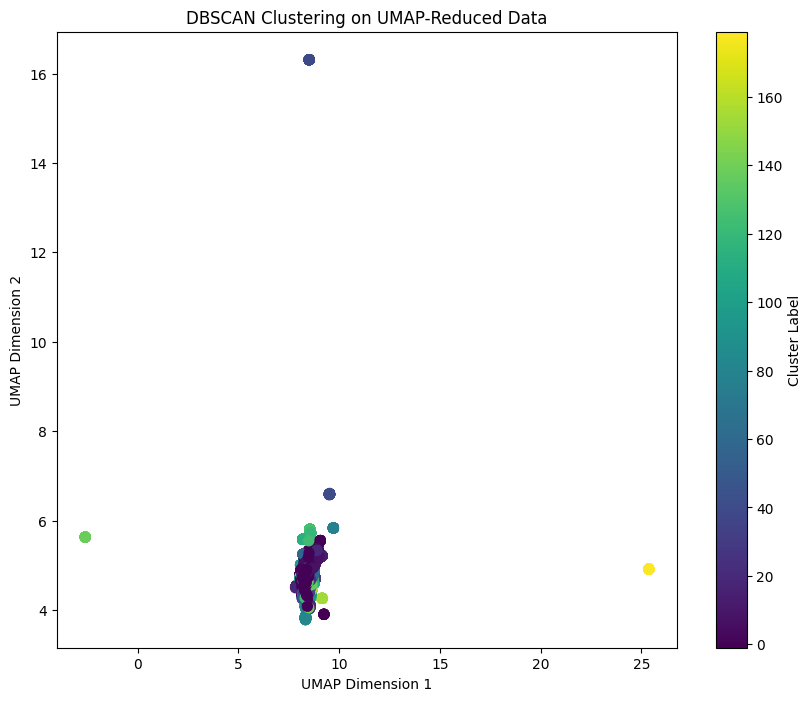

In [5]:
# Step 4: Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('DBSCAN Clustering on UMAP-Reduced Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

##### Post Clustering Tests

In [6]:
print(clusters)

[  0   1   2 ...   0   0 124]


In [7]:
print(clusters.max())

179


In [9]:
df['classes'] = clusters.tolist()
df.head()

,page,caption,title_sentiment_label,title_sentiment_score,caption_sentiment_label,caption_sentiment_score,cleaned_title,embbed_title,classes
0,13db0ab1-eea2-4603-84c4-f40a876c7400,Jeferson da Silva Lima foi escoltado por agent...,NEGATIVE,0.813053,NEGATIVE,0.607570,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"[0.028708808, 0.07910229, -0.04915501, 0.02104...",0
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,As expressões santarenas não significam apenas...,NEUTRAL,0.450133,NEUTRAL,0.683940,Linguajar dos santarenos é diferenciado e chei...,"[0.05066423, 0.053637918, -0.06246449, -0.0591...",1
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,Ex-primeiro-ministro foi atingido por tiros de...,NEGATIVE,0.840971,NEGATIVE,0.845363,Ex-premiê Shinzo Abe morre após ser baleado no...,"[-0.04080393, 0.08898491, -0.041833814, -0.010...",2
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,Ministro defendeu que posse indígena é diferen...,NEGATIVE,0.721313,NEUTRAL,0.766454,"Relator no STF, Fachin vota contra marco tempo...","[-0.02016749, 0.13216536, 0.03784579, -0.01504...",0
4,9dff71eb-b681-40c7-ac8d-68017ac36675,"Pelo marco temporal, índios só podem reivindic...",NEGATIVE,0.844091,NEUTRAL,0.708964,"Após 2 votos, pedido de vista suspende julgame...","[0.031508345, 0.10205304, 0.03989872, 0.017708...",0


In [13]:
titles = df.loc[df['classes']==124, ['cleaned_title']]

In [14]:
print(titles)
# print(titles[22])
# print(titles[40])
# print(titles[985])

                                            cleaned_title
3210    Abdulrazak Gurnah, romancista tanzaniano, ganh...
5072    José Saramago: diário inédito do escritor port...
5176    Professores brasileiros que já foram finalista...
6190    Jornalistas recebem Nobel da Paz por esforços ...
7207    Saiba o que são os  experimentos naturais  pre...
...                                                   ...
244788  Campanha Internacional para a Abolição das Arm...
245922  Investir em educação para a primeira infância ...
245923  O cientista ganhador do Nobel que perdeu seus ...
246780  Joseph Stiglitz, Nobel de Economia:  A surpres...
255602  Filme sobre Malala divulga teaser no dia do an...

[89 rows x 1 columns]


In [15]:
out_filepath = 'local/itens_text_db_scan.parquet'
df.to_parquet(out_filepath, index=False)

##### UMAP JobLib

In [5]:
# Save the trained model using joblib
joblib.dump(reducer, 'local/reducer.joblib')

['local/reducer.joblib']